In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

# Basic Representation

In [2]:
dfbord = pd.read_csv('Data/COUNTRY-BORDERS.csv')
dfbord.head()

,country_code,country_name,country_border_code,country_border_name
0,AD,Andorra,FR,France
1,AD,Andorra,ES,Spain
2,AE,United Arab Emirates,OM,Oman
3,AE,United Arab Emirates,SA,Saudi Arabia
4,AF,Afghanistan,CN,China


In [3]:
dfbord.nunique()

country_code           248
country_name           249
country_border_code    162
country_border_name    163
dtype: int64

In [4]:
# Object Creation
GR = nx.Graph()

vrtxs = dfbord.country_code.unique()
edges = dfbord.dropna().pipe(lambda _df: _df.assign(edges = list(zip(_df['country_code'], _df['country_border_code']))) ).edges.to_list()

GR.add_nodes_from(vrtxs)
GR.add_edges_from(edges)

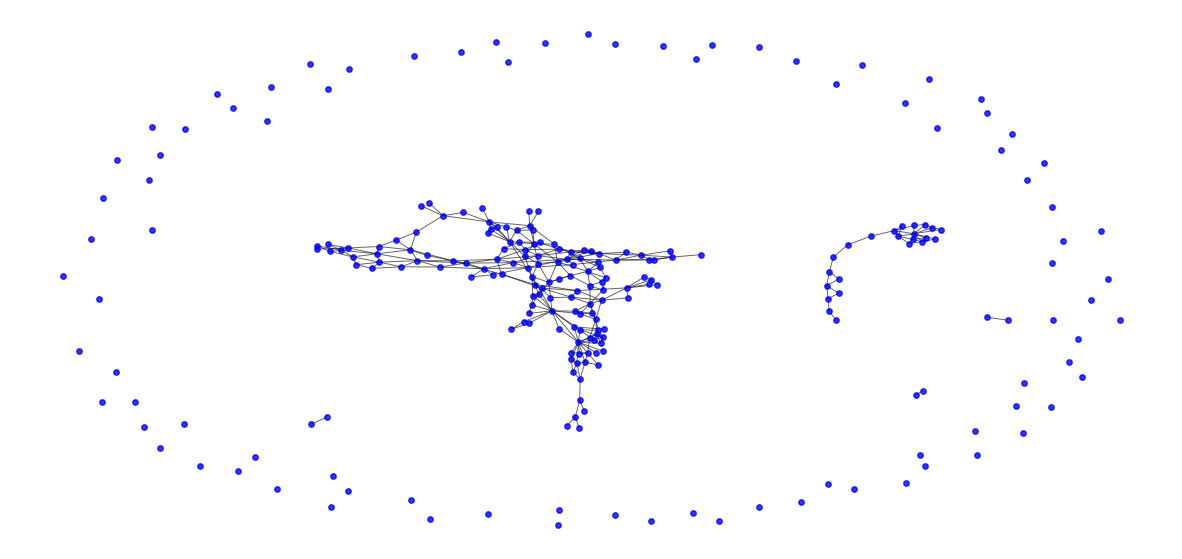

In [5]:
plt.figure(figsize=(15,7))

# Circular Layout
#pos = nx.circular_layout(GR)
#pos = nx.kamada_kawai_layout(GR) #great

pos = nx.spring_layout(GR)

# Draw nodes 
nx.draw_networkx_nodes(GR, pos, node_size=15, node_color='blue', alpha=0.8, label=vrtxs)
# Draw edges
nx.draw_networkx_edges(GR, pos, width=0.7, alpha=0.6)

sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

Top Borders

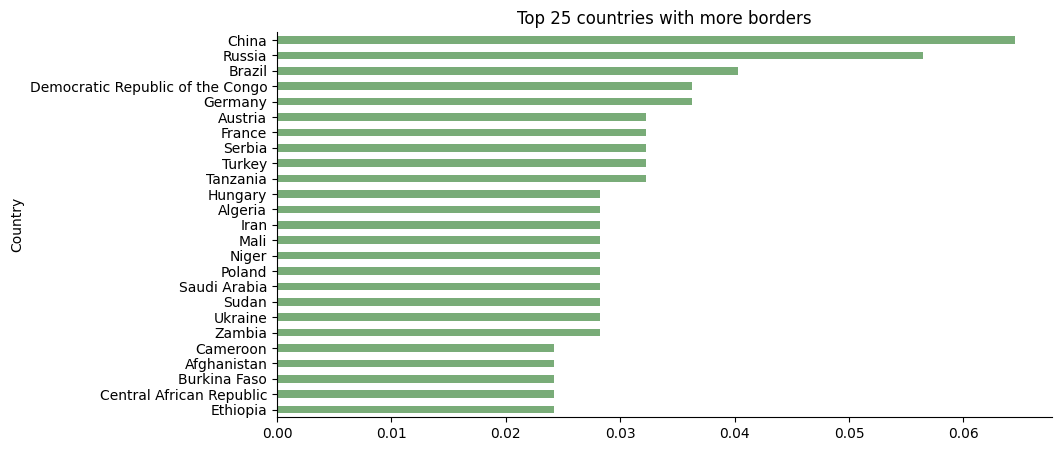

In [6]:
# Reading country names
dfc = pd.read_csv('Data/world-data-2023.csv')

# Calculating the centrality values
dict_centrality_values = nx.degree_centrality(GR)

# Preparing Data with relevant names
topBorders = (
            pd.DataFrame( list(dict_centrality_values.items()), columns=['CountryCode', 'Centrality'] )
            .set_index('CountryCode')
            .merge( dfc.set_index('Abbreviation')[['Country']], left_index=True, right_index=True, how='left')
            .set_index('Country')
            .Centrality
            )

topBorders.nlargest(25).sort_values(ascending=True).plot.barh(figsize=(10,5), title='Top 25 countries with more borders', color=['#79AC78'])

sns.despine(top=True, right=True)
plt.show()

# World Network Detailed

In [48]:
# Getting continental info
dfcont = pd.read_csv('Data/world-administrative-boundaries.csv', sep=";", usecols=['ISO 3166-1 Alpha 2-Codes','Continent of the territory'])
dfcont.set_index('ISO 3166-1 Alpha 2-Codes', inplace=True)
dfcont

,Continent of the territory
ISO 3166-1 Alpha 2-Codes,
MP,Oceania
NaN,Asia
FR,Europe
RS,Europe
UY,Americas
...,...
MQ,Americas
MY,Asia
SE,Europe


In [58]:
dfcont[dfcont.index.isin(['NA'])]

,Continent of the territory
ISO 3166-1 Alpha 2-Codes,


In [40]:
dfcont['Continent of the territory'].value_counts()

Africa        63
Asia          60
Americas      53
Europe        52
Oceania       24
Antarctica     4
Name: Continent of the territory, dtype: int64

In [141]:
fr = (dfbord
        .dropna(subset=['country_code'])
        .set_index('country_code')
        .merge( dfcont, left_index=True, right_index=True, how='left' ) # Add continental info
        .pipe( lambda _df: _df.assign( 
            #country_border_code = np.where( (_df.country_border_code.isna()) & (_df.country_border_name.notnull()), 'NA', _df.country_border_code )
            #,#Namibia is the only country that has no ISO country code in our source, therefore, it is manually corrected.
            _color = np.select( [_df['Continent of the territory'] == 'Europe', _df['Continent of the territory'] == 'Asia',
                                 _df['Continent of the territory'] == 'Africa', _df['Continent of the territory'] == 'Americas',
                                 _df['Continent of the territory'] == 'Oceania',_df['Continent of the territory'] == 'Antarctica'],
                                 ['#04364A', '#FF4848', '#FFD371', '#C2FFD9', '#9DDAC6', '#EE9322'], default='#FCE09B'  )
            ) )
        
        )
fr

,country_name,country_border_code,country_border_name,Continent of the territory,_color
AD,Andorra,FR,France,Europe,#04364A
AD,Andorra,ES,Spain,Europe,#04364A
AE,United Arab Emirates,OM,Oman,Asia,#FF4848
AE,United Arab Emirates,SA,Saudi Arabia,Asia,#FF4848
AF,Afghanistan,CN,China,Asia,#FF4848
...,...,...,...,...,...
ZM,Zambia,ZW,Zimbabwe,Africa,#FFD371
ZW,Zimbabwe,BW,Botswana,Africa,#FFD371
ZW,Zimbabwe,MZ,Mozambique,Africa,#FFD371
ZW,Zimbabwe,ZA,South Africa,Africa,#FFD371


In [142]:
fr.isna().sum()

country_name                   0
country_border_code           90
country_border_name           86
Continent of the territory    15
_color                         0
dtype: int64

In [143]:
# Some discrepancies remain
fr[ (fr.country_border_code.isna()) & (fr['Continent of the territory'].isna())]

,country_name,country_border_code,country_border_name,Continent of the territory,_color
AQ,Antarctica,NaN,NaN,NaN,#FCE09B
AX,Aland Islands,NaN,NaN,NaN,#FCE09B
BL,Saint Barthelemy,NaN,NaN,NaN,#FCE09B
BQ,"Bonaire, Sint Eustatius and Saba",NaN,NaN,NaN,#FCE09B
CW,Curacao,NaN,NaN,NaN,#FCE09B
GG,Guernsey,NaN,NaN,NaN,#FCE09B
GS,South Georgia and the South Sandwich Islands,NaN,NaN,NaN,#FCE09B
IM,Isle of Man,NaN,NaN,NaN,#FCE09B
JE,Jersey,NaN,NaN,NaN,#FCE09B
PM,Saint Pierre and Miquelon,NaN,NaN,NaN,#FCE09B


In [145]:
# Object Creation
GR = nx.Graph()

vrtxs = fr.index.unique()
edges = fr.dropna().pipe(lambda _df: _df.assign(edges = list(zip(_df.index, _df['country_border_code']))) ).edges.to_list()

# Colors
COLORS = fr[~fr.index.duplicated()]._color.to_list()

GR.add_nodes_from(vrtxs)
GR.add_edges_from(edges)

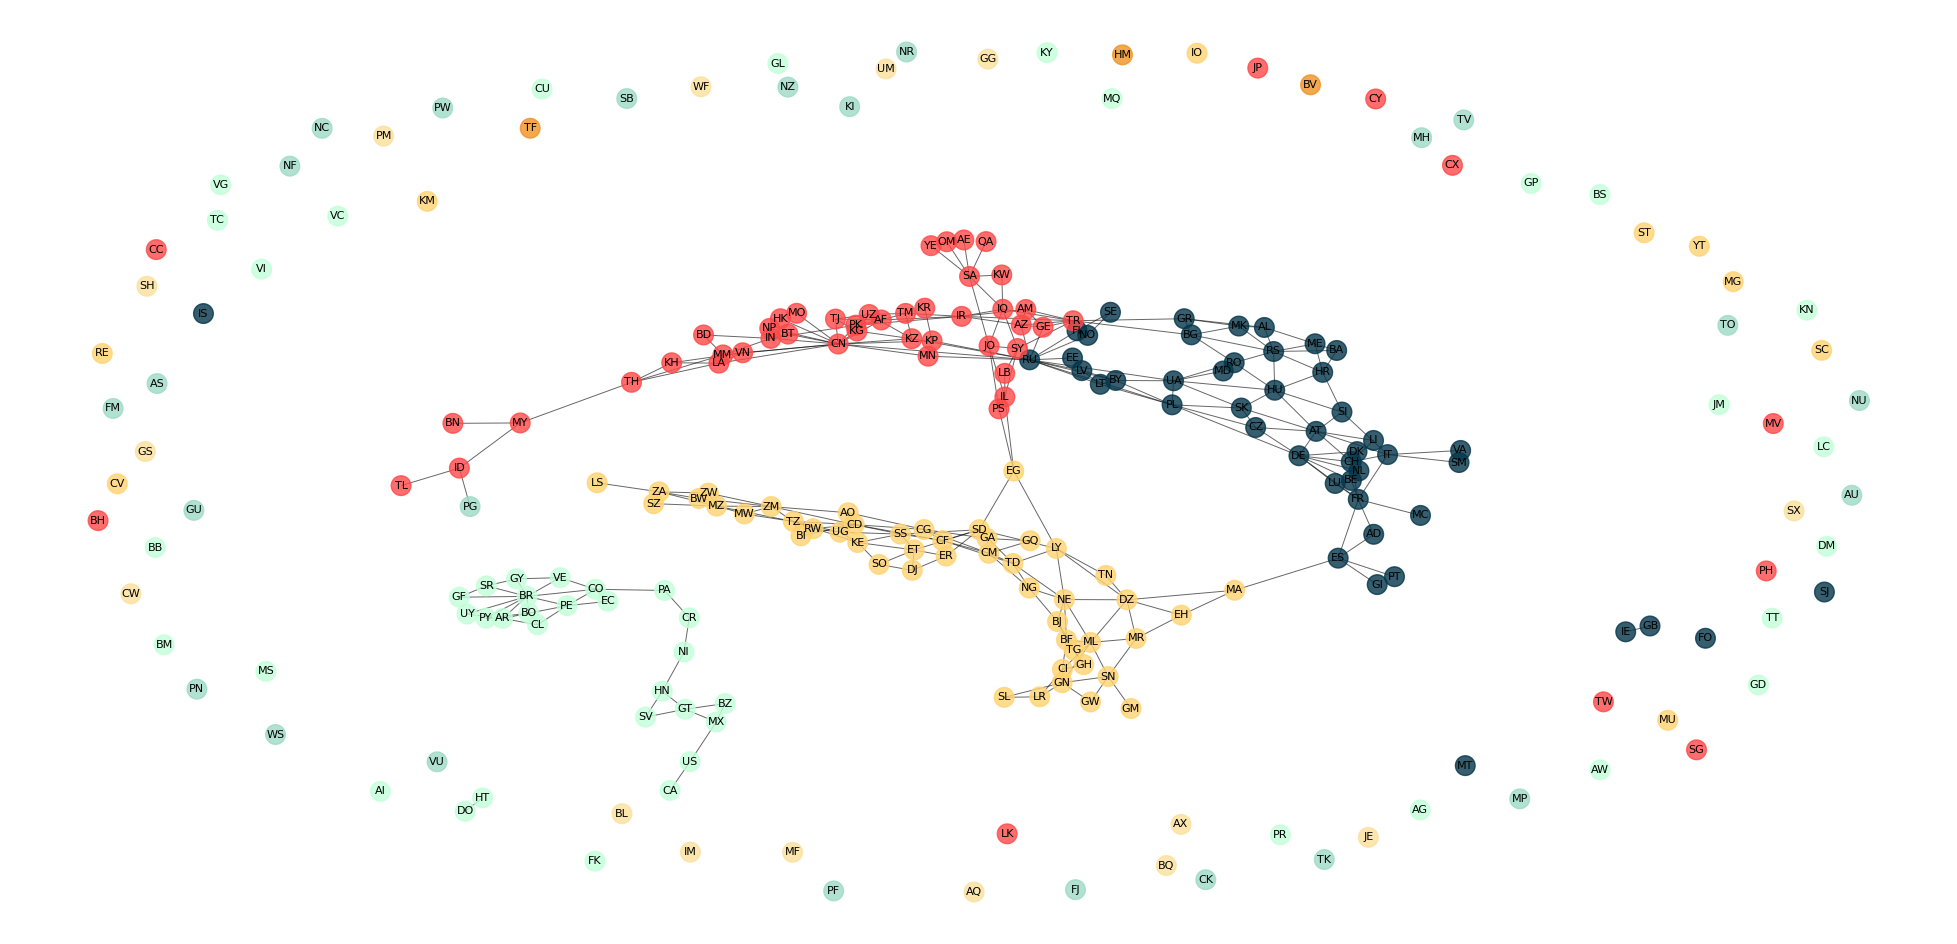

In [162]:
plt.figure(figsize=(25,12))

pos = nx.spring_layout(GR, k=0.09)
#pos = nx.kamada_kawai_layout(GR, scale=3)

# Draw nodes 
nx.draw_networkx_nodes(GR, pos, node_size=200, node_color=COLORS, alpha=0.8)
# Draw edges
nx.draw_networkx_edges(GR, pos, width=0.7, alpha=0.6)
# Draw node labels
nx.draw_networkx_labels(GR, pos, labels={node: node for node in vrtxs}, font_size=8)

sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

In [33]:
dfc[dfc['Abbreviation'].isin(['ID', 'EG'])]

,Country,Density\n(P/Km2),Abbreviation,Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Calling Code,Capital/Major City,Co2-Emissions,...,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban_population,Latitude,Longitude
51,Egypt,103,EG,3.80%,"1,001,450","836,000",26.38,20.0,Cairo,"238,560",...,62.00%,0.45,"100,388,073",46.40%,12.50%,44.40%,10.76%,"42,895,824",26.820553,30.802498
78,Indonesia,151,ID,31.50%,"1,904,569","676,000",18.07,62.0,Jakarta,"563,325",...,48.30%,0.43,"270,203,917",67.50%,10.20%,30.10%,4.69%,"151,509,724",-0.789275,113.921327


In [36]:
dfc.columns

Index(['Country', 'Density\n(P/Km2)', 'Abbreviation', 'Agricultural Land( %)',
       'Land Area(Km2)', 'Armed Forces size', 'Birth Rate', 'Calling Code',
       'Capital/Major City', 'Co2-Emissions', 'CPI', 'CPI Change (%)',
       'Currency-Code', 'Fertility Rate', 'Forested Area (%)',
       'Gasoline Price', 'GDP', 'Gross primary education enrollment (%)',
       'Gross tertiary education enrollment (%)', 'Infant mortality',
       'Largest city', 'Life expectancy', 'Maternal mortality ratio',
       'Minimum wage', 'Official language', 'Out of pocket health expenditure',
       'Physicians per thousand', 'Population',
       'Population: Labor force participation (%)', 'Tax revenue (%)',
       'Total tax rate', 'Unemployment rate', 'Urban_population', 'Latitude',
       'Longitude'],
      dtype='object')

In [35]:
dfbord[dfbord['country_code'].isin(['ID', 'EG'])]

,country_code,country_name,country_border_code,country_border_name
210,EG,Egypt,IL,Israel
211,EG,Egypt,LY,Libya
212,EG,Egypt,PS,"Palestine, State of"
213,EG,Egypt,SD,Sudan
306,ID,Indonesia,MY,Malaysia
307,ID,Indonesia,PG,Papua New Guinea
308,ID,Indonesia,TL,Timor-Leste
